# Financial News Sentiment Analysis

### Description

This classification task is based on the Kaggle dataset: <a href=https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis >Financial Sentiment Analysis</a>. The dataset is under public domain license (v10.0).

---
### Table of contents

1. [Dataset](#dataset)
2. [Data preparation](#preparation)
3. [Classification](#classification)
   1. [Simple Conv](#)
   2. [LSTM](#)
   3. [GRU](#)
   4. [Bidirectional](#)
   5. [Conv1d](#)
   6. [FinBERT](#finbert)
4. [Model Comparison](#comparison)

---
## 1. Dataset

In [189]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score,recall_score,precision_score
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras import layers
from scipy import stats
import warnings
import sys

In [190]:
df = pd.read_csv("data//data.csv")

neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64


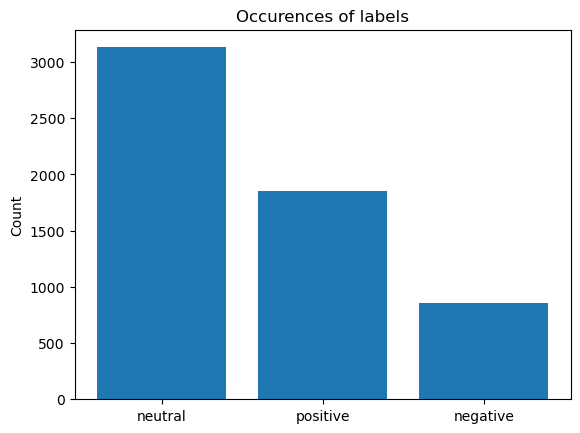

In [191]:
fig,ax = plt.subplots()
ax.bar(df["Sentiment"].value_counts().index,df["Sentiment"].value_counts().values)
ax.set_ylabel("Count")
ax.set_title("Occurences of labels")
print(df["Sentiment"].value_counts())

Dataset is **imbalanced**: almost 2x positive label than negative and 2x neutral label than positive.

**Solution**: use imblearn RandomOverSampler. (Under-sampling would make dataset insufficiently small)

## 2. Data Preparation

In [192]:
encoder = LabelEncoder()
encoder.fit(df["Sentiment"])

LabelEncoder()

In [193]:
X = df["Sentence"]
y = encoder.transform(df["Sentiment"])

In [194]:
print(encoder.classes_)

['negative' 'neutral' 'positive']


In [195]:
print(y)

[2 0 2 ... 1 1 2]


In [196]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

In [197]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(4673,) (1169,) (4673,) (1169,)


In [198]:
sampler = RandomOverSampler(random_state=42)
X_over, y_over = sampler.fit_resample(X_train.to_numpy().reshape(-1, 1), y_train.reshape(-1, 1))

In [199]:
y_train = np.asarray(y_over).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [200]:
print(X_over.shape,y_over.shape)

(7548, 1) (7548,)


In [201]:
avg_words=round(sum([len(i.split()) for i in X_train])/len(X_train))

In [202]:
text_vectorizer = TextVectorization(max_tokens=10000,
                                    output_mode="int",
                                    output_sequence_length=avg_words)
text_vectorizer.adapt(X_train)

In [203]:
embedding = layers.Embedding(input_dim=10000, 
                             output_dim=128, 
                             embeddings_initializer="uniform", 
                             input_length=avg_words, 
                             name="embedding_1")

## 3. Classification

In [204]:
def get_scores(y_hat,y_true,model_name="model"):
    return {
        "model":model_name,
        "f1":f1_score(y_hat,y_true,average="weighted"),
        "accuracy":accuracy_score(y_hat,y_true),
        "recall": recall_score(y_hat,y_true,average="weighted"),
        "precision":precision_score(y_hat,y_true,average="weighted")
    }

### 3.1 Simple Keras CNN

In [205]:
inputs = layers.Input(shape=(1,), dtype="string") 
x = text_vectorizer(inputs) 
x = embedding(x) 
x = layers.GlobalAveragePooling1D()(x) 
outputs = layers.Dense(3, activation='softmax')(x) 
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") 

model_1.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [206]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 21)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 21, 128)           1280000   
                                                                 
 global_average_pooling1d_5   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_20 (Dense)            (None, 3)                 387       
                                                                 
Total params: 1,280,387
Trainable params: 1,280,387
N

In [207]:
model_1_history = model_1.fit(X_over, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              y_over,
                              epochs=10,verbose=0 )

#### 3.2 LSTM estimator

In [208]:
embedding_layer = layers.Embedding(input_dim=10000,
                                   output_dim=128,
                                   embeddings_initializer="uniform",
                                   input_length=avg_words,
                                   name="embedding1")
inputs = layers.Input(shape=(1,),dtype="string")

x = text_vectorizer(inputs)
x= embedding_layer(x)
x = layers.LSTM(units=64)(x)
outputs = layers.Dense(3, activation="softmax")(x)

lstm_model = tf.keras.Model(inputs,outputs,name="lstm_model")

lstm_model.compile(loss="sparse_categorical_crossentropy",
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=["accuracy"])

In [209]:
lstm_model.summary()

Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 21)               0         
 ectorization)                                                   
                                                                 
 embedding1 (Embedding)      (None, 21, 128)           1280000   
                                                                 
 lstm_20 (LSTM)              (None, 64)                49408     
                                                                 
 dense_21 (Dense)            (None, 3)                 195       
                                                                 
Total params: 1,329,603
Trainable params: 1,329,603
Non-trainable params: 0
______________________________________________

In [210]:
lstm_history = lstm_model.fit(X_over,y_over,epochs=10,verbose=0)

In [211]:
lstm_model.evaluate(X_test,y_test)

37/37 [==============================] - 1s 7ms/step - loss: 2.0948 - accuracy: 0.6228


[2.0947606563568115, 0.6227545142173767]

#### 3.3 GRU estimator

In [212]:
embedding_layer3 = layers.Embedding(input_dim=10000,
                                          output_dim =128,
                                          embeddings_initializer = "uniform",
                                          input_length=avg_words,
                                          name="embedding3")
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding_layer3(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(3, activation="softmax")(x)

gru_model = tf.keras.Model(inputs,outputs,name="gru_model")

gru_model.compile(loss="sparse_categorical_crossentropy",
                  optimizer = tf.keras.optimizers.Adam(),
                  metrics=["accuracy"]
                  )

In [213]:
gru_history  = gru_model.fit(X_over,y_over,epochs=10,verbose=0)

In [214]:
gru_model.evaluate(X_test,y_test)

37/37 [==============================] - 1s 8ms/step - loss: 1.7858 - accuracy: 0.6467


[1.7857528924942017, 0.6467065811157227]

#### 3.4 Bidirectional Estimator

In [215]:
embedding_layer4 = layers.Embedding(input_dim=10000,
                                    output_dim=128,
                                    embeddings_initializer="uniform",
                                    input_length=avg_words,
                                    name="embedding4")

inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding_layer4(x)
x = layers.Bidirectional(layers.LSTM(64,))(x)
outputs = layers.Dense(3,activation="softmax")(x)

bdir_model = tf.keras.Model(inputs,outputs,name="bdir_model")
bdir_model.compile(loss="sparse_categorical_crossentropy",
                   optimizer = tf.keras.optimizers.Adam(),
                   metrics = ["accuracy"])

In [216]:
bdir_history = bdir_model.fit(X_over,y_over,epochs=10,verbose=0)

In [217]:
bdir_model.evaluate(X_test,y_test)

37/37 [==============================] - 1s 10ms/step - loss: 2.0937 - accuracy: 0.6347


[2.093658924102783, 0.6347305178642273]

#### 3.5 Conv1d Estimator

In [218]:
embedding_layer5 = layers.Embedding(input_dim=10000,
                                    output_dim=128,
                                    embeddings_initializer="uniform",
                                    input_length=avg_words,
                                    name="embedding5")

inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding_layer5(x)

x = layers.Conv1D(filters=32,kernel_size=5,activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(3,activation="softmax")(x)

conv1d_model = tf.keras.Model(inputs,outputs,name="conv1d_model")
conv1d_model.compile(loss="sparse_categorical_crossentropy",
                   optimizer = tf.keras.optimizers.Adam(),
                   metrics = ["accuracy"])

In [219]:
conv1d_history = conv1d_model.fit(X_over,y_over,epochs=10,verbose=0)

Epoch 1/10
236/236 [==============================] - 3s 11ms/step - loss: 0.8650 - accuracy: 0.6553
Epoch 2/10
236/236 [==============================] - 3s 11ms/step - loss: 0.3537 - accuracy: 0.8764
Epoch 3/10
236/236 [==============================] - 3s 11ms/step - loss: 0.2019 - accuracy: 0.9316
Epoch 4/10
236/236 [==============================] - 3s 11ms/step - loss: 0.1643 - accuracy: 0.9428
Epoch 5/10
236/236 [==============================] - 2s 10ms/step - loss: 0.1539 - accuracy: 0.9416
Epoch 6/10
236/236 [==============================] - 3s 11ms/step - loss: 0.1467 - accuracy: 0.9444
Epoch 7/10
236/236 [==============================] - 3s 12ms/step - loss: 0.1414 - accuracy: 0.9462
Epoch 8/10
236/236 [==============================] - 3s 11ms/step - loss: 0.1396 - accuracy: 0.9462
Epoch 9/10
236/236 [==============================] - 2s 10ms/step - loss: 0.1370 - accuracy: 0.9495
Epoch 10/10
236/236 [==============================] - 2s 10ms/step - loss: 0.1343 - accura

In [220]:
conv1d_model.evaluate(X_test,y_test)

37/37 [==============================] - 0s 5ms/step - loss: 1.1841 - accuracy: 0.6595


[1.1840994358062744, 0.6595380902290344]

#### 3.6 FinBERT (hugging-face)

In [221]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import pipeline
finbert = TFBertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

Some layers from the model checkpoint at yiyanghkust/finbert-tone were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at yiyanghkust/finbert-tone.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [222]:
nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)
results = nlp(X_test.tolist())

In [223]:
y_pred_finbert =[]
for result in results:
    if result["label"] =="Negative":
        y_pred_finbert.append(0)
    elif result["label"] =="Neutral":
        y_pred_finbert.append(1)
    else:
        y_pred_finbert.append(2)

In [224]:
finbert_acc = get_scores(y_pred_finbert,y_test,"finBERT")

In [225]:
finbert = TFBertForSequenceClassification.from_pretrained('ProsusAI/finbert',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [226]:
nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)
results = nlp(X_test.tolist())

In [227]:
y_pred_finbert_base =[]
for result in results:
    if result["label"] =="negative":
        y_pred_finbert_base.append(0)
    elif result["label"] =="neutral":
        y_pred_finbert_base.append(1)
    else:
        y_pred_finbert_base.append(2)

In [228]:
finbert_base_acc = get_scores(y_pred_finbert_base,y_test,"finBERT")

## 4. Model Comparison

In [229]:
y_pred_cnn = model_1.predict(X_test)
y_pred_lstm = lstm_model.predict(X_test)
y_pred_conv1d = conv1d_model.predict(X_test)
y_pred_gru = gru_model.predict(X_test)
y_pred_bdir = bdir_model.predict(X_test)

37/37 [==============================] - 1s 10ms/step


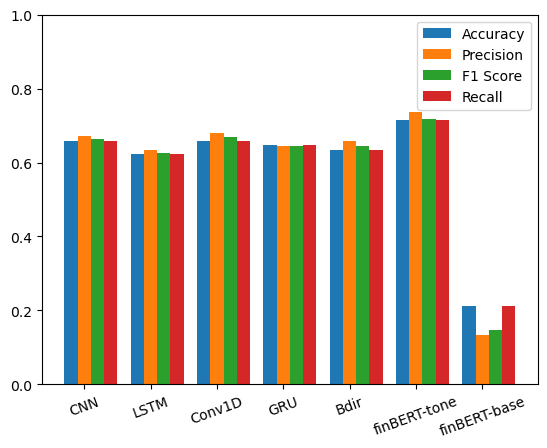

In [230]:
acc_scores = []
prec_scores = []
f1_scores = []
recall_scores = []

for preds in [y_pred_cnn,y_pred_lstm,y_pred_conv1d,y_pred_gru,y_pred_bdir]:
    y_hat = []
    for pred in preds:
        if max(pred) ==pred[0]:
            y_hat.append(0)
        elif max(pred) ==pred[1]:
            y_hat.append(1)
        else:
            y_hat.append(2)
    acc_scores.append(get_scores(y_hat, y_test)["accuracy"])
    prec_scores.append(get_scores(y_hat, y_test)["precision"])
    f1_scores.append(get_scores(y_hat, y_test)["f1"])
    recall_scores.append(get_scores(y_hat, y_test)["recall"])
    
acc_scores +=[finbert_acc["accuracy"],finbert_base_acc["accuracy"]]
prec_scores +=[finbert_acc["precision"],finbert_base_acc["precision"]]
recall_scores +=[finbert_acc["recall"],finbert_base_acc["recall"]]
f1_scores +=[finbert_acc["f1"],finbert_base_acc["f1"]]
fig = plt.figure()

barWidth = 0.2
br1 = np.arange(len(acc_scores))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]



plt.bar(br1,acc_scores,width=barWidth,label="Accuracy")
plt.bar(br2,prec_scores,width=barWidth,label="Precision")
plt.bar(br3,f1_scores,width=barWidth,label="F1 Score")
plt.bar(br4,recall_scores,width=barWidth,label="Recall")
plt.xticks([r + barWidth for r in range(len(acc_scores))],
        ["CNN","LSTM","Conv1D","GRU","Bdir","finBERT-tone","finBERT-base"],rotation=20)
plt.ylim(0,1)
plt.legend()
plt.show()

Best accuracy: finBERT-tone 71.26%

## Can we do better?

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer


In [234]:
def predict_scores(clf,X_over,y_over,X_test,y_test):
    
    clf.fit(X_over,y_over)
    y_hat = clf.predict(X_test)
    return get_scores(y_hat,y_test)

In [245]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df["Sentence"]),np.array(df["Sentiment"]), test_size=0.25, random_state=42)

In [246]:
tfidf = TfidfVectorizer(use_idf=True, tokenizer=word_tokenize,min_df=0.00002,max_df=0.70)
X_train_tf = tfidf.fit_transform(X_train.astype('U'))
X_test_tf = tfidf.transform(X_test.astype('U'))

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/english.pickle[0m

  Searched in:
    - 'C:\\Users\\nemet/nltk_data'
    - 'c:\\Users\\nemet\\anaconda3\\nltk_data'
    - 'c:\\Users\\nemet\\anaconda3\\share\\nltk_data'
    - 'c:\\Users\\nemet\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\nemet\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************


In [232]:
estimators = [RandomForestClassifier(),CatBoostClassifier(),XGBClassifier(),KNeighborsClassifier()]

for clf in estimators:
    scores = predict_scores(clf,X_over,y_over,X_test,y_test)
    

NameError: name 'RandomForestClassifier' is not defined